# A/B testing and power analysis

## What is A/B Testing?

A/B testing is a methodology for testing the efficacy of a new product or feature on the internet. To run the experiment, you need 2 sets of users --

1. a "control" set that uses the pre-existing product or feature
2. an "experiment" set that uses a new, experimental version

Then you measure how users respond differently between the two sets to determine if the feature is "better."

Some examples --

* "Our experiments demonstrate that slowing down the search results page by 100 to 400 milliseconds has a measurable impact on the number of searches per user of -0.2% to -0.6%" ([Google Research Blog](https://research.googleblog.com/2009/06/speed-matters.html))
* "'Add more color to your professional identity by showing what you care about' [...] The A/B test showed a 14% increase in edits of volunteer experience in member profiles!" ([LinkedIn Engineering Blog](https://engineering.linkedin.com/ab-testing/xlnt-platform-driving-ab-testing-linkedin))
* "Identify artwork that enabled members to find a story they wanted to watch faster." ([Netflix Tech Blog](https://medium.com/netflix-techblog/selecting-the-best-artwork-for-videos-through-a-b-testing-f6155c4595f6))

## An example business case: funnel analysis

Imagine that you're a data scientist working at a startup that sells fidget spinners. Despite the highly game-changing nature of the company's product, sales are not too impressive. You wonder if the company's online store experience can be modified somehow to augment sales. Fortunately, your web developer coworker already equiped the website with tools to track traffic! You add up the visits to each page of the site over the past month, and you observe the following funnel in the user flow --

1. Visit the front page (**60,000** visits)
2. Visit the catalog page (**5,000** visits)
3. Visit a product spinner details page (**4,900** visits)
4. Visit cart page (**4,700** visits)
5. Checkout and payment page (**4,600** visits)
6. Payment confirmation page (**4,600** visits)

A major bottle neck in the visitor-to-sale conversion rate seems to be happening between steps 1 and 2. Once users get to the catalog page and see the fidget spinners, the product pretty much sells itself. Many serious meetings take place after you share this funnel analysis with your company, and a new design is proposed for the button on the front page linking to the catalog page (a very slick, animated button that looks and spins exactly like a real fidget spinner).

You've been assigned the task of designing and running an experiment to determine if the proposed animated button is a good idea.

## Refining the problem
### Initial hypothesis
Changing the catalog button to a spinning fidget button will increase the number of users who visit the catalog page.

### Possible metrics
1. Click-through rate (CTR)
$$\text{CTR} = \frac{\text{# of clicks}}{\text{# of page views}}$$
  - Good for measuring __usability__ of the site (includes double-clicks or going back and re-clicking)
2. Click-through probability (CTP)
$$\text{CTP} = \frac{\text{# of unique visitors who click at least once}}{\text{# of unique visitors to the page}}$$
  - Good for measuring __impact__ (e.g. are users progressing to the next level of the funnel?)
  - Some ways to measure: $$\frac{\text{# of cookies that click}}{\text{# of cookies}}\text{ or }\frac{\text{# of page views w/ click}}{\text{# of page views}}$$

The chosen metric matters, e.g. if $\text{user}_{1}$ clicks 0 times and $\text{user}_{2}$ clicks 5 times, then $\text{CTR} = 2.5$ and $\text{CTP} = 0.5$.

### Reframe hypothesis in terms of a chosen metric
Changing the catalog button to a spinning fidget button will increase the __click-through-probability__ of the button.

## Clicks by visitors can be described as a binomial distribution

Properties of a binomial distribution:
1. Two possible outcomes: success or failure (click or no click)
2. Independent events
3. Identical distribution (probability of success is the same for all events)

This means that if the true probability of clicks is $p$, the total population size (e.g. total visitors) is $n$, and the number of successes is $x$, then the distribution has the following properties:

$$\text{population mean} = p = \frac{x}{n}$$
$$\text{population standard deviation} = \sigma = \sqrt{\frac{\left(p\right)\left(1-p\right)}{n}}$$

When we do $N$ experiments (i.e. Bernoulli trails) and count $X$ successes to measure an unknown probability of success, we get the following

$$\text{sample mean} = \hat{p} = \frac{X}{N}$$
$$\text{sample standard error} = SE = \sqrt{\frac{\left(\hat{p}\right)\left(1-\hat{p}\right)}{N}}$$

## Confidence interval calculation

If we can approximate the sample as a normal distribution, then we can calculate the margin of error around the mean for a desired confidence interval. The following criteria are typically checked before assuming a normal distribution.

$$N \times \hat{p} \gt 5$$
$$N \times \left(1 - \hat{p}\right) \gt 5$$

One can see that binomial distribution is too truncated to use a normal approximation when these criteria are not true.

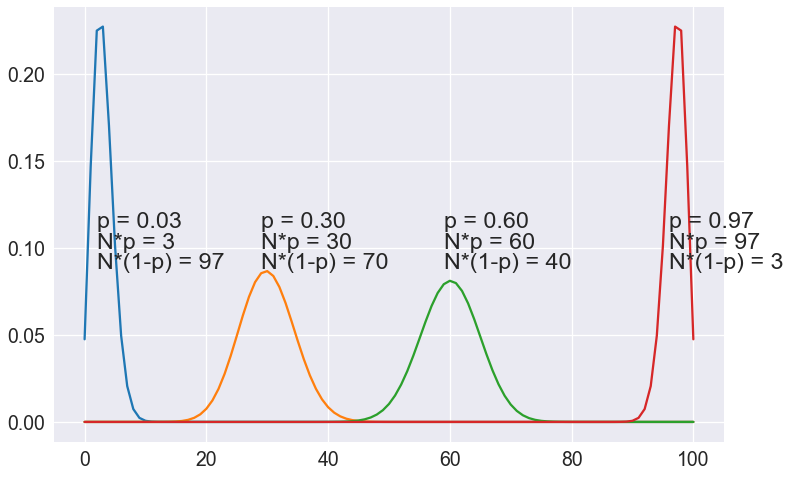

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk', font_scale=1.5)
sns.set_style('darkgrid') 
plt.rcParams['figure.figsize'] = 12, 8
import scipy
from scipy.stats import binom 
N = 100
ps = [0.03, 0.3, 0.6, 0.97]
for idx, p in enumerate(ps):
    x = scipy.linspace(0, N, N + 1)
    plt.plot(x, binom.pmf(x, N, p))
    text_x = (N * p) - 1
    text_y = 0.1
    plt.text(text_x, text_y + 0.012, 'p = {:.2f}'.format(p))
    plt.text(text_x, text_y, 'N*p = {:.0f}'.format(N * p))
    plt.text(text_x, text_y - 0.012, 'N*(1-p) = {:.0f}'.format(N * (1-p)))
plt.show()

If the normal approximation is valid, then we can use the z-score to calculate a two-tailed 95% confidence interval. One way to find the z-score is look it up in a z-score table: https://www.math.upenn.edu/~yuecheng/images/zscoretable.pdf

In [2]:
from scipy.stats import norm
one_tailed_confidence_interval = 0.975
z_score = norm.ppf(one_tailed_confidence_interval)  # Percent Point Function (Inverse of CDF)
print('z-score for two-tailed 95% confidence interval: {:.2f}'.format(z_score))

z-score for two-tailed 95% confidence interval: 1.96


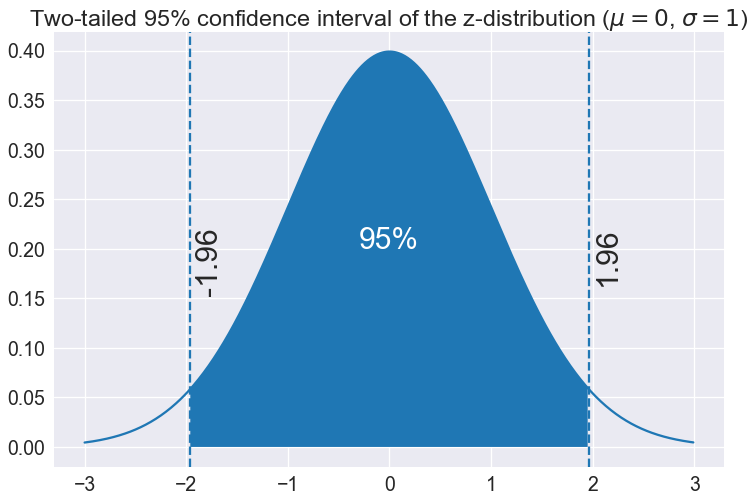

In [14]:
import numpy as np
x_axis = np.arange(-3, 3, 0.01)
plt.plot(x_axis, norm.pdf(x_axis,0,1))
x_axis_fill = np.arange(-z_score, z_score, 0.01)
plt.fill_between(x_axis_fill, norm.pdf(x_axis_fill,0,1))
text_y = 0.2
plt.axvline(z_score, linestyle='dashed')
plt.axvline(-z_score, linestyle='dashed')
plt.text(-0.3, text_y, '95%', color='white', size=30)
plt.text(z_score + 0.05, text_y, '{:0.2f}'.format(z_score), size=30, rotation=90)
plt.text(- z_score + 0.05, text_y, '-{:0.2f}'.format(z_score), size=30, rotation=90)
plt.title('Two-tailed 95% confidence interval of the z-distribution ($\mu = 0$, $\sigma = 1$)')
plt.show()

The confidence interval, i.e. the margin of error, for a normal distribution is the z-score of the confidence level times the standard error.

$$\text{margin of error} = \text{z-score} \times SE = \text{z-score} \times \sqrt{\frac{\left(\hat{p}\right)\left(1-\hat{p}\right)}{N}}$$

One thing to note here: the amount of random variation that we expect in the sample (i.e, the width of the confidence interval) is a function of
1. the proportion of successes $\hat{p} \left(1 - \hat{p}\right)$ (the distribution is tighter when the click probability is further from 0.5)
2. the size of the sample $N$

So, if $X = 300$, $N = 2000$, and the confidence interval is 99%, the margin of error is as follows.

z-score for two-tailed 99% confidence interval: 2.58


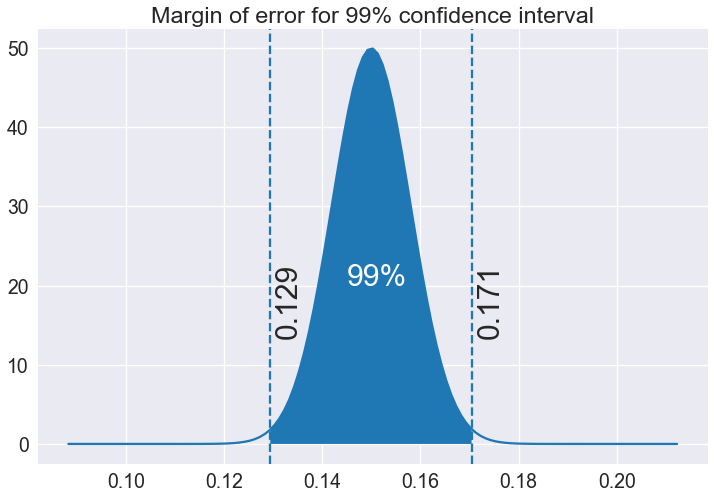

In [15]:
one_tailed_confidence_interval = 0.995
z_score = norm.ppf(one_tailed_confidence_interval)
print('z-score for two-tailed 99% confidence interval: {:.2f}'.format(z_score))

X = 300
N = 2000
p = X / N
SE = (p * (1-p) / N)**0.5
margin_of_error = z_score * SE

step_size = 0.001
x_axis = np.arange(p - 3*margin_of_error, p + 3*margin_of_error + step_size, step_size)
plt.plot(x_axis, norm.pdf(x_axis, p, SE))
x_axis_fill = np.arange(p - margin_of_error, p + margin_of_error, step_size)
plt.fill_between(x_axis_fill, norm.pdf(x_axis_fill, p, SE))
text_y = 20
plt.axvline(p + margin_of_error, linestyle='dashed')
plt.axvline(p - margin_of_error, linestyle='dashed')
plt.text(p - 0.005, text_y, '99%', color='white', size=30)
plt.text(p + margin_of_error + 0.001, text_y, '{:0.3f}'.format(p + margin_of_error), size=30, rotation=90)
plt.text(p - margin_of_error + 0.001, text_y, '{:0.3f}'.format(p - margin_of_error), size=30, rotation=90)
plt.title('Margin of error for 99% confidence interval')
plt.show()


## The null and alternative hypotheses

If $p_{ctrl}$ represents the true probability of a click with the original button design and $p_{exp}$ represents the true probability of a click with the new, experimental fidget-spinner button design. Then we have the following hypotheses:

$$H_{0}\text{ (null hypothesis) : } p_{exp} - p_{ctrl} = 0 $$
$$H_{A}\text{ (alternative hypothesis) : } p_{exp} - p_{ctrl} \ne 0 $$

An approach we can take to show that the true probabilities are different is to look at the difference of the measured sample means.
1. Measure $\hat{p}_{exp}$ and $\hat{p}_{ctrl}$
2. Calculate $P(\hat{p}_{exp} - \hat{p}_{ctrl} \mathbin{\vert} H_{0})$
3. Reject $H_{0}$

## Comparing two samples

Let's say we have two samples
1. Control
  - $X_{ctrl}$ is the number of users who clicked
  - $N_{ctrl}$ is the total number of users
2. Experiment
  - $X_{exp}$ is the number of users who clicked
  - $N_{exp}$ is the total number of users


### The pooled mean and SE describe the null hypothesis

$$\hat{p}_{pool} = \frac{X_{ctrl} + X_{exp}}{N_{ctrl} + N_{exp}}$$
$$SE_{pool} = \sqrt{\hat{p}_{pool} \left(1 - \hat{p}_{pool}\right) \left(\frac{1}{N_{ctrl}} + \frac{1}{N_{exp}}\right)}$$

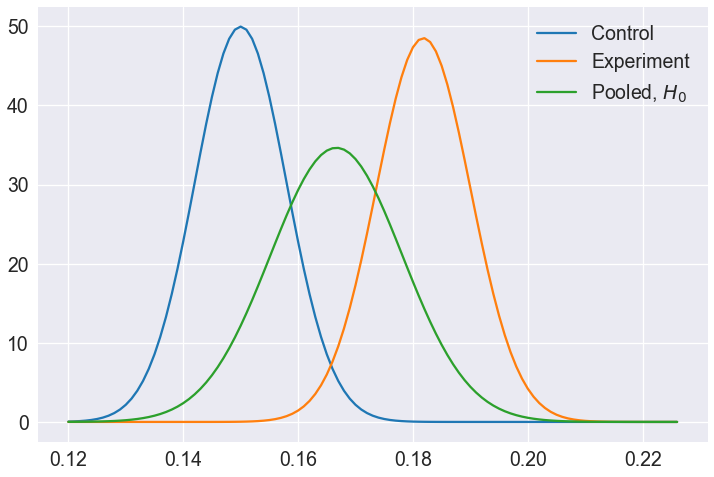

In [16]:
def calc_p(X_hyp, N_hyp):
    return X_hyp / N_hyp
    
def calc_SE(p_hyp, N_hyp):
    return (p_hyp * (1-p_hyp) / N_hyp)**0.5
    
def plot_hypothesis(p_hyp, SE_hyp, lbl_txt):
    step_size = 0.001
    x_axis = np.arange(0.12, 0.225 + step_size, step_size)
    plt.plot(x_axis, norm.pdf(x_axis, p_hyp, SE_hyp), label=lbl_txt)

X_ctrl, N_ctrl = 300, 2000
X_exp, N_exp = 400, 2200
plot_hypothesis(calc_p(X_ctrl, N_ctrl), calc_SE(calc_p(X_ctrl, N_ctrl), N_ctrl), lbl_txt='Control')
plot_hypothesis(calc_p(X_exp, N_exp), calc_SE(calc_p(X_exp, N_exp), N_exp), lbl_txt='Experiment')

p_pool = (X_ctrl + X_exp) / (N_ctrl + N_exp)
SE_pool = (p_pool*(1-p_pool)*((1/N_ctrl) + (1/N_exp)))**0.5
plot_hypothesis(p_pool, SE_pool, lbl_txt='Pooled, $H_{0}$')
plt.legend(loc='best')
plt.show()

### Difference of the means

And let's use $\hat{d}$ to describe the difference of the means.

$$\hat{d} = \hat{p}_{exp} - \hat{p}_{ctrl}$$

Under the null hypothesis $H_{0} \text{ : } d = 0$, so we expect the estimate $\hat{d}$ to be normally distributed with a standard deviation of the pooled SE, i.e. $\mathcal{N}\left(0, SE_{pool}\right)$.

We can __reject__ the null hypothesis, $H_{0}$, if the difference of the means falls outside the pooled margin of error.
$$\hat{d} > 1.96 \times SE_{pool} \text{ or } \hat{d} < - 1.96 \times SE_{pool}$$



### An example

Let's say that we ran an experiment with the two button types, and we had the following results:

$$X_{ctrl} = 900$$
$$N_{ctrl} = 10000$$
$$X_{exp} = 1200$$
$$N_{exp} = 9000$$

And we are requiring a minimum effect of $d_{min} = 0.03$ with a confidence level of 95%. Using what we've covered so far, we can determine whether or not we should launch this new button design based on the results of this experiment.

In [80]:
X_ctrl, N_ctrl, X_exp, N_exp = 900, 10000, 1200, 9000
p_pool = (X_ctrl + X_exp) / (N_ctrl + N_exp)
print('p_pool is {:.4f}'.format(p_pool))
SE_pool = (p_pool * (1-p_pool) *((1/N_ctrl)+(1/N_exp)))**0.5
print('SE_pool is {:.4f}'.format(SE_pool))
d = (X_exp / N_exp) - (X_ctrl / N_ctrl)
print('d hat, the estimated difference, is {:.4f}'.format(d))
one_tailed_confidence_interval = 0.975
z_score_95 = norm.ppf(one_tailed_confidence_interval)
margin = z_score_95 * SE_pool
print('margin of error is {:.4f}'.format(margin))
print('the confidence interval spans {:.4f} to {:.4f}'.format(d - margin, d + margin))

p_pool is 0.1105
SE_pool is 0.0046
d hat, the estimated difference, is 0.0433
margin of error is 0.0089
the confidence interval spans 0.0344 to 0.0523


Altogether, these results would indicate that the company should launch the fidget spinner button! The results surpass the 3% practical significance level requirement and does so with at least a 95% confidence level.

So we know how to use the results of an A/B testing experiment. Now lets look at how to design the test, namely how many samples to collect.

## Size vs. power trade off

There are two kinds of errors that can arise when comparing samples between a control and an experiment group.

$$\alpha = \text{rate of Type I error} = P(\text{reject } H_{0} \mathbin{\vert} H_{0} \text{ true})$$
$$\beta = \text{rate of Type II error} = P(\text{fail to reject } H_{0} \mathbin{\vert} H_{0} \text{ false})$$

Also, from $\beta$ we get the power of our test.

$$\text{power (aka sensitivity)} = 1 - \beta$$

The cut off for the false positive rate $\alpha$ is usually set to 0.05 and the cut off for the false negative rate $\beta$ is usually set to 0.2, i.e. a power of 0.8.

Power has an inverse trade-off with size: the smaller the change that you want to detect or the increased confidence that you want to have in your result, the more page views you will need to record in the control and experimental groups.

### When samples are small, $\alpha$ (probability of falsely concluding that there is a difference) is low and $\beta$ (probability of falsely failing to draw a conclusion) is high.

This is because the margin of error narrows as you collect more data.

z-score for two-tailed 95% confidence interval: 1.96


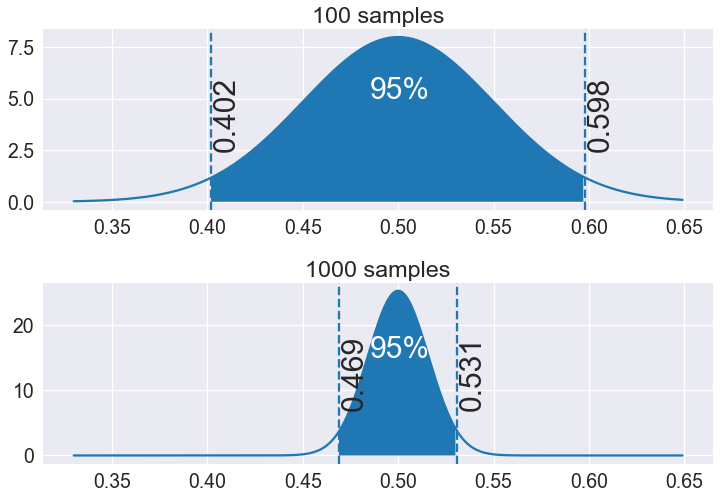

In [17]:
one_tailed_confidence_interval = 0.975
z_score = norm.ppf(one_tailed_confidence_interval)
print('z-score for two-tailed 95% confidence interval: {:.2f}'.format(z_score))

def plot_marg_of_error(X, N, text_y, title):
    p = X / N
    SE = (p * (1-p) / N)**0.5
    margin_of_error = z_score * SE

    step_size = 0.001
    x_axis = np.arange(0.33, 0.65, step_size)
    plt.plot(x_axis, norm.pdf(x_axis, p, SE))
    x_axis_fill = np.arange(p - margin_of_error, p + margin_of_error, step_size)
    plt.fill_between(x_axis_fill, norm.pdf(x_axis_fill, p, SE))
    plt.axvline(p + margin_of_error, linestyle='dashed')
    plt.axvline(p - margin_of_error, linestyle='dashed')
    plt.text(p - 0.015, text_y, '95%', color='white', size=30)
    plt.text(p + margin_of_error + 0.001, text_y, '{:0.3f}'.format(p + margin_of_error), size=30, rotation=90)
    plt.text(p - margin_of_error + 0.001, text_y, '{:0.3f}'.format(p - margin_of_error), size=30, rotation=90)
    plt.title(title)

X = 50
N = 100
plt.subplot('211')
plot_marg_of_error(X, N, 5, '100 samples')
X = 500
N = 1000
plt.subplot('212')
plot_marg_of_error(X, N, 15, '1000 samples')
plt.subplots_adjust(hspace=0.4)
plt.show()

### When the effect size is small, increasing the samples decreases $\beta$ but $\alpha$ remains unchanged

In [18]:
# First let's define a function for plotting the null and alternative hypotheses
def plot_null_and_alternative_hypotheses(X_ctrl, N_ctrl, X_exp, N_exp, title):
    one_tailed_confidence_interval = 0.975
    z_score = norm.ppf(one_tailed_confidence_interval)
    print('z-score for two-tailed 95% confidence interval: {:.2f}'.format(z_score))

    step_size = 0.001
    x_min, x_max = 0.35, 0.55
    x_axis = np.arange(x_min, x_max, step_size)

    # The null hypothesis
    p_null = (X_ctrl + X_exp) / (N_ctrl + N_exp)
    SE_null = (p_null*(1-p_null)*((1/N_ctrl) + (1/N_exp)))**0.5
    margin_of_error_null = z_score * SE_null
    plt.plot(x_axis, norm.pdf(x_axis, p_null, SE_null), label='$H_{0}$')

    # SE = SD / sqrt(N)
    cohens_d = ((X_exp / N_exp) - (X_ctrl / N_ctrl))/np.sqrt(p_null*(1-p_null))
    print("cohen's d is {}".format(cohens_d))
    
    # Type I error, false positive rate if the null hypothesis is true
    x_axis_fill = np.arange(p_null + margin_of_error_null, x_max, step_size)
    plt.fill_between(x_axis_fill, norm.pdf(x_axis_fill, p_null, SE_null), facecolor='blue', alpha=0.5, label='Type I error')

    # The alternative hypothesis
    X_alt = X_exp
    N_alt = N_exp
    p_alt = calc_p(X_alt, N_alt)
    SE_alt = calc_SE(p_alt, N_alt)
    plt.plot(x_axis, norm.pdf(x_axis, p_alt, SE_alt), label='$H_{A}$')

    # Type II error, false positive rate if the null hypothesis is true
    x_axis_fill = np.arange(x_min, p_null + margin_of_error_null, step_size)
    plt.fill_between(x_axis_fill, norm.pdf(x_axis_fill, p_alt, SE_alt), facecolor='orange', alpha=0.5, label='Type II error')
    plt.title(title)
    plt.legend(loc='best')

First, let's plot a case when both the control and experiments have 1000 samples.

z-score for two-tailed 95% confidence interval: 1.96
cohen's d is 0.10114434748483471


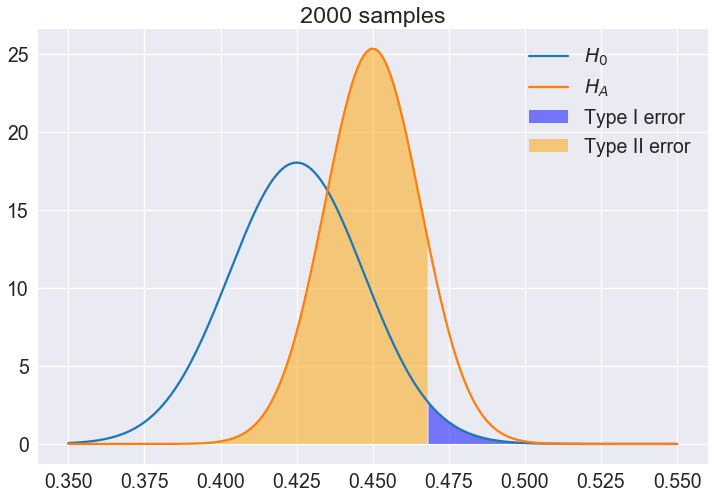

In [19]:
X_ctrl, N_ctrl = 400, 1000
X_exp, N_exp = 450, 1000
plot_null_and_alternative_hypotheses(X_ctrl, N_ctrl, X_exp, N_exp, title='2000 samples')
plt.show()

Now, consider the case when we have seven times as many samples.

z-score for two-tailed 95% confidence interval: 1.96
cohen's d is 0.10114434748483471


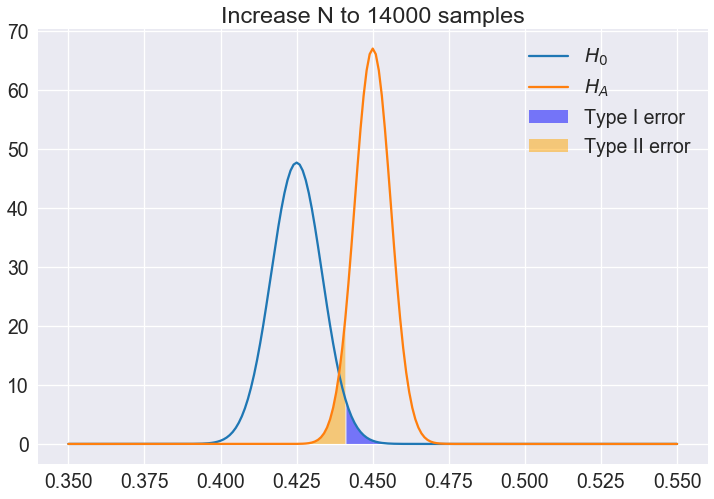

In [81]:
X_ctrl, N_ctrl = 400*7, 1000*7
X_exp, N_exp = 450*7, 1000*7
plot_null_and_alternative_hypotheses(X_ctrl, N_ctrl, X_exp, N_exp, title='Increase N to 14000 samples')
plt.show()

__NB: $\beta$ has noticeably decreases but $\alpha$ remains unchanged!__

Also, note that $\beta$ disappears with a sufficiently large effect size. This means that we could get away with a smaller sample size and still have enough power to assert a difference in the control and experimental populations.

z-score for two-tailed 95% confidence interval: 1.96
cohen's d is 0.36597765571301005


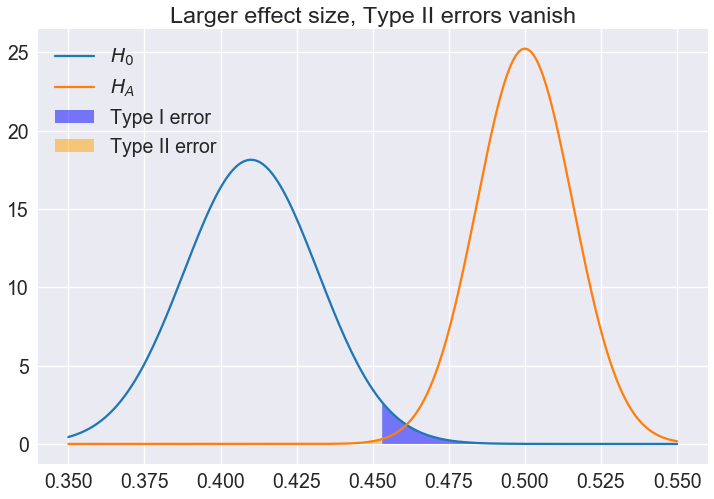

In [21]:
X_ctrl, N_ctrl = 320, 1000
X_exp, N_exp = 500, 1000
plot_null_and_alternative_hypotheses(X_ctrl, N_ctrl, X_exp, N_exp, title="Larger effect size, Type II errors vanish")
plt.show()

### Okay, okay! Enough with the distribution plots. How do I calculate how many samples I need for my experiment?

There's actually a formula for this (I found it here http://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_power/BS704_Power_print.html).

$$N_{i} = 2\left(\frac{Z_{1-\alpha/2} + Z_{1-\beta}}{ES}\right)^{2}$$

where $N_{i}$ is the sample size required in each group (i=1,2), $\alpha$ is the selected level of significance and $Z_{1-\alpha/2}$ is the z-score that corresponds to the $1-\alpha/2$ confidence interval. $Z_{1-\beta}$ is the z-score for the desired power. Finally, $ES$ is the effect size, defined as:

$$ES = \frac{\left|p_{exp} - p_{ctrl}\right|}{\sigma} = \frac{\left|p_{exp} - p_{ctrl}\right|}{\sqrt{ p_{pool} \left( 1 - p_{pool} \right) }}$$

where the numerator is the expected difference under $H_{A}$, the alternative hypothesis, and $\sigma$ is the standard deviation. Using the standard cut off values for $\alpha$ at 0.05 and $\beta$ at 0.2, i.e. a power of 0.8, the formula now looks like this --

$$N_{i} = 2 \left(\frac{Z_{0.975} + Z_{0.8}}{ES}\right)^{2}$$

We can look up the z-scores. It might be worth remembering these numbers if this question comes up in an interview. Not sure.

In [39]:
z_score_975 = norm.ppf(0.975)
print('z-score for two-tailed 95% confidence interval: {:.2f}'.format(z_score_975))
z_score_80 = norm.ppf(0.8)
print('z-score for 80% power (20% Type II error rate): {:.2f}'.format(z_score_80))

z-score for two-tailed 95% confidence interval: 1.96
z-score for 80% power (20% Type II error rate): 0.84


For example, we can calculate the minimum necessary sample size for the control and experiment groups with the numbers from before

In [52]:
X_ctrl, N_ctrl, X_exp, N_exp = 900, 10000, 1200, 9000
p_ctrl = calc_p(X_ctrl, N_ctrl)
p_exp = calc_p(X_exp, N_exp)
p_pool = (X_ctrl + X_exp) / (N_ctrl + N_exp)
d = p_exp - p_ctrl
SD = np.sqrt(p_pool*(1-p_pool))
ES = d / SD
2 * ((z_score_975 + z_score_80) / ES)**2

821.8494569484642

For fun, we can visualize how power changes with respect to some of its parameters

In [56]:
def convert_to_power(N, d, p_pool):
    ES = d / np.sqrt(p_pool * (1-p_pool))
    z_score_80 = (np.sqrt(N / 2) * ES) - norm.ppf(0.975)
    return norm.cdf(z_score_80)
convert_to_power(821, d, p_pool)

0.7995943058769738

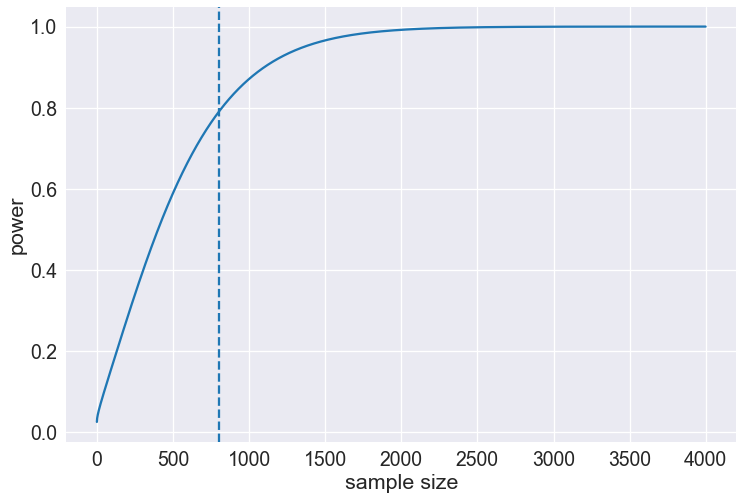

In [79]:
x_axis = np.arange(0, 4000, 1)
plt.plot(x_axis, convert_to_power(x_axis, d, p_pool))
plt.axvline(800, linestyle='dashed')
plt.xlabel('sample size')
plt.ylabel('power')
plt.show()

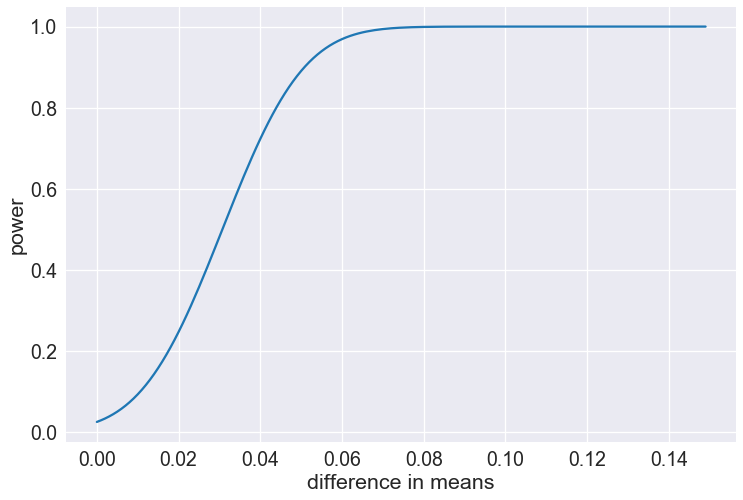

In [75]:
x_axis = np.arange(0, 0.15, 0.001)
plt.plot(x_axis, convert_to_power(800, x_axis, p_pool))
plt.xlabel('difference in means')
plt.ylabel('power')
plt.show()

/anaconda3/envs/insight/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


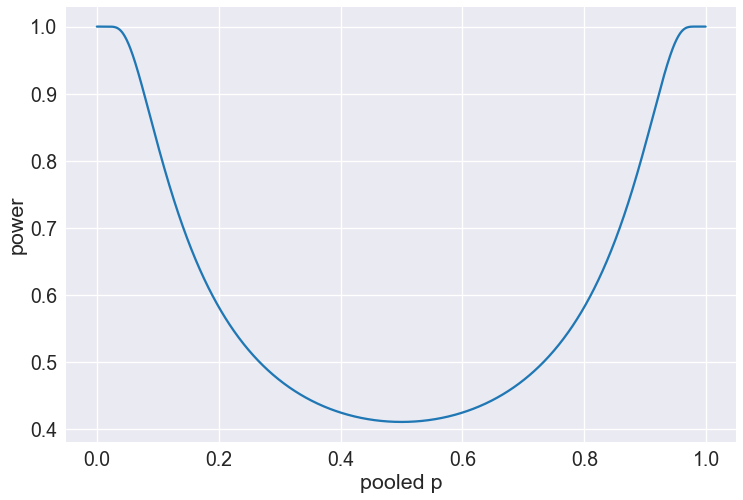

In [74]:
x_axis = np.arange(0, 1, 0.001)
plt.plot(x_axis, convert_to_power(800, d, x_axis))
plt.xlabel('pooled p')
plt.ylabel('power')
plt.show()

# Reminds of the plots here https://www.statisticsdonewrong.com/power.html

### My attempt at deriving the necessary sample size formula. Something isn't right in the math though. Not sure what ... yet.

The threshold for $\alpha$ and $\beta$ fall on the exact same value, i.e. the margins of error for $H_{0}$ and $H_{A}$ meet in the middle.

$$p_{null} + Z_{0.975} \times SE_{null} = p_{exp} - Z_{0.8} \times SE_{exp} $$

Substituting in $SE_{null} = \sqrt{\frac{p_{null}\left(1 - p_{null}\right)}{N_{null}}}$ and $SE_{exp} = \sqrt{\frac{p_{exp}\left(1 - p_{exp}\right)}{N_{exp}}}$ gives

$$p_{null} + Z_{0.975} \times \sqrt{\frac{p_{null}\left(1 - p_{null}\right)}{N_{null}}} = p_{exp} - Z_{0.8} \times \sqrt{\frac{p_{exp}\left(1 - p_{exp}\right)}{N_{exp}}} $$

Let's apply a few assumptions.

First, let's assume that the control and experiment groups have the same size: $N_{ctrl} = N_{exp} = \frac{N_{null}}{2} = N_{i}$, where $i$ is ctrl or exp.

$$p_{null} + Z_{0.975} \times \sqrt{\frac{p_{null}\left(1 - p_{null}\right)}{N_{i}}} = p_{exp} - Z_{0.8} \times \sqrt{\frac{p_{exp}\left(1 - p_{exp}\right)}{N_{i}}} $$

Next, let's say that the null hypothesis $H_{0}$ sits right in between the control and experiment, i.e. if the difference in means is $\hat{d} = \hat{p}_{exp} - \hat{p}_{ctrl}$, then $\frac{\hat{d}}{2} = \hat{p}_{exp} - \hat{p}_{null}$

$$p_{null} + Z_{0.975} \times \sqrt{\frac{p_{null}\left(1 - p_{null}\right)}{N_{i}}} = p_{null} + \frac{d}{2} - Z_{0.8} \times \sqrt{\frac{p_{exp}\left(1 - p_{exp}\right)}{N_{i}}} $$

Then cancel out $p_{null}$

$$Z_{0.975} \times \sqrt{\frac{p_{null}\left(1 - p_{null}\right)}{N_{i}}} = \frac{d}{2} - Z_{0.8} \times \sqrt{\frac{p_{exp}\left(1 - p_{exp}\right)}{N_{i}}} $$

$$Z_{0.975} \times \sqrt{\frac{p_{null}\left(1 - p_{null}\right)}{N_{i}}} + Z_{0.8} \times \sqrt{\frac{p_{exp}\left(1 - p_{exp}\right)}{N_{i}}}= \frac{d}{2} $$

$$\frac{1}{{\sqrt{N_{i}}}}\left(Z_{0.975}\sqrt{p_{null}\left(1 - p_{null}\right)} + Z_{0.8}\sqrt{p_{exp}\left(1 - p_{exp}\right)}\right)= \frac{d}{2} $$

$$\sqrt{N_{i}} = 2\frac{Z_{0.975}\sqrt{p_{null}\left(1 - p_{null}\right)} + Z_{0.8}\sqrt{p_{exp}\left(1 - p_{exp}\right)}}{d}$$

If we can assume that $\sqrt{p_{null}\left(1 - p_{null}\right)} \approx \sqrt{p_{exp}\left(1 - p_{exp}\right)}$

$$\sqrt{N_{i}} = 2\frac{Z_{0.975} + Z_{0.8}}{\frac{d}{\sqrt{p_{null}\left(1 - p_{null}\right)}}}$$

And if effect size is $ES = \frac{d}{\sqrt{p_{null}\left(1 - p_{null}\right)}}$

$$\sqrt{N_{i}} = 2\frac{Z_{0.975} + Z_{0.8}}{ES}$$
$$N_{i} = \left(2\frac{Z_{0.975} + Z_{0.8}}{ES}\right)^{2}$$
$$N_{i} = 4\left(\frac{Z_{0.975} + Z_{0.8}}{ES} \right)^{2}$$